# Dictionary/Compromized Passwords Attack Mitigation

## Preliminary Thoughts

### Threat Model: Distributed Dictionary Attack
The rudimentary model is that of an attacker with budget $B$ using our password validation/reset page to iterate through a dictionary of passwords, searching for a matching ccid/password combination. Suppose the cost of renting a single bot is $C$, and the probability of successfully guessing a password is $p$, independent of previous attempts.

The probability of needing to take more than $k$ attempts to guess a password is then the complement of the CDF of geometric distribution with parameter $p$, $$P(K>k) = (1-p)^k =: e^{-\alpha}$$

If we allow $n$ attempts from a single IP address before blocking it, the cost of guessing $k$ times for the attacker is $Ck/n$, so that $$n = \frac{Ck}{B} = \frac{C}{B}\times\frac{-\alpha}{\ln(1-p)} = \frac{C}{B}\times\frac{\alpha}{p+p^2+O(p^3)} \approx \frac{C}{B}\times2^b \alpha = \frac{2^b \alpha}{S}$$
Where $b$ is the password bit complexity: $p=2^{-b}$ and $S$ the botnet size $S:=\frac{B}{C}$.

For a weak password of 7 alphanumeric characters (35 bits of password complexity), $2^{35}=34\times10^9$ so that if we set the remaining parameters $C=\$10, B=\$100k, \alpha=100$ we get $$n \approx 3\times10^8$$
That is, for an attacker with the budget of $\$100k$ whose cost of renting an IP exit point is $\$10$, even after making 10 queries/second for a year, the probability of success would still be vanishingly small.

Thus, our vulnerability is primarily to extremely weak or leaked passwords, where the probability of a correct guess is over one in a few thousand: $p\approx 10^{-4}$.
Then, for $\alpha=10$ (probability of attack succeeding under $0.01\%$), $C=\$10, B=\$100k$, $$n\approx 10$$

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

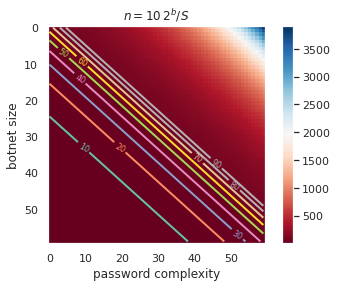

In [116]:
from numpy import exp,arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

alpha = 10
def n(b,S):
 return alpha * 2**b / 10**S
 
x = arange(16, 22, (22-16)/60)
y = arange(4, 6, (6-4)/60)
X,Y = meshgrid(x, y)
Z = n(X, Y)

im = imshow(Z,cmap=cm.RdBu)
cset = contour(  Z
               , arange(10, 100, 10)
               , linewidths = 2
               , cmap = cm.Set2)
clabel( cset
       , inline = True
       , fmt = '%1.0f'
       , fontsize = 8)

colorbar(im) 
title('$n=10\, 2^b/S$')
plt.ylabel('botnet size')
plt.xlabel('password complexity')

show()

### Detection
We know very little about the true requestor of single password validation/reset, but we do know a fair amount about the target CCID of the request. We should leverage this information on which CCIDs we have, their RTIs, use pattern --- e.g. last login and associated data. In this threat model, an attacker is assumed to know RTI information and target high-value accounts, but this is a pattern we should be able to identify.

- canary ccid/password: e.g. svc_superadmin
- check against known leaked passwords
- how often do users check their passwords *before* trying to authenticate to any of our services?
- what is the typical activity *after* a password is confirmed?
- is password verification by IST analyst a common occurence? What about multiple IST analysts on the same day? What about ccids issued to executives?
- how often password verification requests come from the same ASN? Can we extend reputation of a single suspicious actor to the entire ASN?

We should treat the activity data, including recent password check/reset activity and inferences thereon, as data products in their own right,  and make them avaiable across our systems. In particular, it may well be of value for the security team to have a list of CCIDs with recently validated/reset passwords in an application. Similarly, if we have evidence some IP addresses are used for brute force attacks, they should be referenced against similar databases used by security. Conversely, IPs on e.g. spam RBLs should be treated as suspicious for the purposes of password resets. Lists of leaked passwords should also be used to proactively monitor password complexity.

### Mitigation
This needs thought. Of course we can throttle the number of password resets from an IP address. If we detect an attack targeted against a group of CCIDs (e.g. IST analysts) be acted upon? How, is it possible, without making the reaction mechanism a vector for DOS attack?

In [30]:
import pandas as p